<a href="https://colab.research.google.com/github/Eminent01/AMMI-RL/blob/main/Copy_of_%5BAMMI_2022%5D_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Licence


In [ ]:
#Licence
#Copyright 2021 Google LLC.
#SPDX-License-Identifier: Apache-2.0

#Deep Q-Network

This practical aims at implementing, from scratch, a working <a href="https://arxiv.org/abs/1312.5602">Deep Q-learning</a> agent on a simple Catch game.

##Installation

### Install required libraries

1. [Acme](https://github.com/deepmind/acme) is a library of reinforcement learning (RL) agents and agent building blocks.

2. [Haiku](https://github.com/deepmind/dm-haiku) is a neural network library for JAX that we saw in the previous practical.

3. [dm_env](https://github.com/deepmind/dm_env): DeepMind Environment API, which will be covered in more details in the [Environment subsection](https://colab.research.google.com/drive/1oKyyhOFAFSBTpVnmuOm9HXh5D5ekqhh5#scrollTo=I6KuVGSk4uc9) below.1

In [1]:
#@title Installations  { form-width: "30%" }

!pip install dm-acme
!pip install dm-acme[reverb]
!pip install dm-acme[jax]
!pip install dm-acme[tf]
!pip install dm-acme[envs]
!pip install dm-env
!pip install dm-haiku
!pip install chex
!pip install imageio
!pip install gym

from IPython.display import clear_output
clear_output()

In [2]:
#@title Imports  { form-width: "30%" }

import IPython

import base64
import chex
import collections
from collections import namedtuple
import dm_env
import enum
import functools
import gym
import haiku as hk
import io
import itertools
import jax
from jax import tree_util
import optax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import reverb
import rlax
import time
from bsuite import environments
import bsuite.environments.catch as dm_catch

import warnings

np.set_printoptions(precision=3, suppress=1)

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


# 1. Environment

We here focus on a very simple environment: Catch!

The agent must move a paddle to intercept falling balls. Falling balls only
move downwards on the column they are in.
The observation is an array shape (rows, columns), with binary values:
zero if a space is empty; 1 if it contains the paddle or a ball.
The actions are discrete, and by default there are three available:
stay, move left, and move right.
The episode terminates when the ball reaches the bottom of the screen.

The first thing you are going to do is implement a random policy on this environment, i.e. a policy that returns a uniformly random action, whatever the observation received.


In [3]:
# @title **[Implement]** Random policy { form-width: "30%" }
def random_policy(obs: chex.Array, num_actions: int) -> chex.Array:
  return np.random.randint(num_actions)

In [4]:
# @title Interacting with the environment.
num_episodes = 1

environment = dm_catch.Catch(rows=5)
int2action = {0: "left", 1: "none", 2: "right"}
Na = environment.action_spec().num_values

for episode in range(num_episodes):

  # Reset any counts and start the environment.
  timestep = environment.reset()

  # Run an episode.
  while not timestep.last():

    print(timestep.observation)

    # Generate an action from the agent's policy and step the environment.
    action = random_policy(timestep.observation, Na)
    timestep = environment.step(action)
    print('')
    print('Action: ', int2action[action])
    print('')


print(timestep.observation)
print("End of episode")
print("Final reward:", timestep.reward)

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]

Action:  left

[[0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]

Action:  left

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]

Action:  none

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]

Action:  none

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
End of episode
Final reward: 1.0


/usr/local/lib/python3.7/dist-packages/bsuite/environments/catch.py:103: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int, num_values=len(_ACTIONS), name="action")


# 2. Q-Learning and DQN on catch

## 2.1. Implementing Q-learning on catch

Catch is a finite state, finite action environment, with few state and actions. It is thus possible to directly implement Q-learning on it. This is the first thing we are going to do.

Contrary to the previous environment we have seen, the environment does not provide a list of all accessible states, and it is thus not possible to fill in all the values of $Q_0(s, a)$ in advance. We are going to fill in our approximate Q-function on the fly. To do this we are going to make use of a dictionary, with keys being pairs of state and actions, and values the corresponding Q-function. Each time we encounter a state action pair that we haven't seen before, we are adding this pair to the dictionary.

One small difficulty is that a dictionary cannot use a numpy array as a key, and our states are represented as numpy arrays. To circumvent that problem, we provide two function, `np_to_hash`and `hash_to_np`that transform a numpy array state into a tuple.

In [11]:
# @title **[Read and understand]** State conversions { form-width: "30%" }
from typing import *

def np_to_hash(state: chex.Array) -> Tuple[int, int, int, int]:
  """Converts a state to a tuple of int. 
  
  For instance, the state
  [[1. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 1. 0. 0.]]
  is converted to [0, 0, 4, 2], e.g. we are encoding the positions of the
  two only non zero elements in the array.
  """
  x, y = np.nonzero(state)
  return (x[0], y[0], x[1], y[1])

def hash_to_np(hash: Tuple[int, int, int, int], nb_rows: int, nb_cols: int) -> chex.Array:
  """Inverse function of np_to_hash."""
  state = np.zeros((nb_rows, nb_cols))
  state[hash[0], hash[1]] = 1.
  state[hash[2], hash[3]] = 1.
  return state

With those two functions, you should now be able to implement Q-learning on the catch environment. Fill in the `sample_action` and `update` method of the QAgent class, then run this agent on the Catch environment.

In [27]:
# @title **[Implement]** Q-learning { form-width: "30%" }
class QAgent:
    """Q-learning with epsilon-greedy exploration."""
    def __init__(self, env: dm_env.Environment, gamma: float, epsilon: float, alpha: float):
      self.qfunction = {}
      self._env = env
      self._epsilon = epsilon
      self._Na = env.action_spec().num_values
      self._alpha = alpha
      self._gamma = gamma

    
    def sample_action(self, state: chex.Array, greedy: bool = False) -> int:
      hash = np_to_hash(state)
      randnum = np.random.uniform(0,1)
      if hash not in self.qfunction:
        self.qfunction[hash] = np.zeros((self._Na,))

      if greedy:
        action = np.argmax(self.qfunction[hash])
      else:
        if randnum < self._epsilon:
          action = random_policy(hash, self._Na)
        else:
          action = np.argmax(self.qfunction[hash])
      return action
    
    def update(self, state: chex.Array, action: int, next_state: chex.Array, reward: float, done: bool) -> None:
      hash = np_to_hash(state)
      if hash not in self.qfunction:
        self.qfunction[hash] = np.zeros(self._Na)
      if done:
        self.qfunction[hash][action] = (1-self._alpha)*self.qfunction[hash][action] + self._alpha*reward
        return
      if not done:
        next_hash = np_to_hash(next_state)
        if next_hash not in self.qfunction:
          self.qfunction[next_hash] = np.zeros(self._Na)
        self.qfunction[hash][action] = (1-self._alpha)*self.qfunction[hash][action] + self._alpha*(reward + self._gamma *np.max(self.qfunction[next_hash]))

/usr/local/lib/python3.7/dist-packages/bsuite/environments/catch.py:103: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int, num_values=len(_ACTIONS), name="action")


Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	-0.4
	5	|	0.0
	10	|	-0.8
	15	|	0.0
	20	|	0.0
	25	|	-0.8
	30	|	-0.4
	35	|	0.0
	40	|	0.0
	45	|	0.6
	50	|	0.0
	55	|	-0.2
	60	|	0.2
	65	|	1.0
	70	|	0.2
	75	|	0.4
	80	|	1.0
	85	|	0.6
	90	|	0.6
	95	|	0.8
	100	|	0.8
	105	|	0.0
	110	|	0.6
	115	|	0.6
	120	|	0.4
	125	|	1.0
	130	|	0.8
	135	|	1.0
	140	|	1.0
	145	|	1.0
	150	|	1.0
	155	|	1.0
	160	|	1.0
	165	|	1.0
	170	|	1.0
	175	|	1.0
	180	|	1.0
	185	|	1.0
	190	|	1.0
	195	|	1.0
	200	|	1.0
	205	|	1.0
	210	|	1.0
	215	|	1.0
	220	|	1.0
	225	|	1.0
	230	|	1.0
	235	|	1.0
	240	|	1.0
	245	|	1.0
	250	|	1.0
	255	|	1.0
	260	|	1.0
	265	|	1.0
	270	|	1.0
	275	|	1.0
	280	|	1.0
	285	|	1.0
	290	|	1.0
	295	|	1.0
	300	|	1.0
	305	|	1.0
	310	|	1.0
	315	|	1.0
	320	|	1.0
	325	|	1.0
	330	|	1.0
	335	|	1.0
	340	|	1.0
	345	|	1.0
	350	|	1.0
	355	|	1.0
	360	|	1.0
	365	|	1.0
	370	|	1.0
	375	|	1.0
	380	|	1.0
	385	|	1.0
	390	|	1.0
	395	|	1.0
	400	|	1.0
	405	|	1.0
	410	|

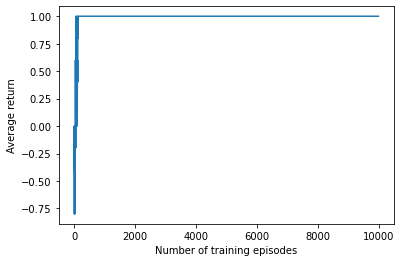

In [28]:
# @title Running Q-learning.
import matplotlib.pyplot as plt

num_episodes = 10000
num_eval_episodes = 10
eval_every_N = 5
alpha = .03
epsilon = .3
gamma = .9

environment = dm_catch.Catch(rows=5)
int2action = {0: "left", 1: "none", 2: "right"}
Na = environment.action_spec().num_values

agent = QAgent(environment, gamma, epsilon, alpha)
all_rewards = []
episodes = []

def run_episode(agent: QAgent, env: dm_catch.Catch, eval: bool) -> float:
  # Reset any counts and start the environment.
  timestep = environment.reset()
  state = timestep.observation

  # Run an episode.
  while not timestep.last():

    # Generate an action from the agent's policy and step the environment.
    action = agent.sample_action(timestep.observation, greedy=eval)
    timestep = environment.step(action)
    next_state = timestep.observation
    reward = timestep.reward
    done = timestep.last()
    if not eval:
      agent.update(state, action, next_state, reward, done)
    state = next_state

  return reward

print("Episode number:\t| Average reward on 100 eval episodes")
print("------------------------------------------------------")

for episode in range(num_episodes):
  run_episode(agent, environment, eval=False)

  if episode % eval_every_N == 0:
    reward = np.mean([run_episode(agent, environment, eval=True) for _ in range(num_eval_episodes)])
    print(f"\t{episode}\t|\t{reward}")
    all_rewards.append(reward)
    episodes.append(episode)

plt.xlabel('Number of training episodes')
plt.ylabel('Average return')
plt.plot(episodes, all_rewards)

## 2.2. Deep Q-Learning on Catch

Now that we have a working version of Q-Learning on Catch, we are going to try to implement Deep Q-Learning on this same environment. To that end, we need mostly need three core components:
 - a function approximator (here, a neural network),
 - a replay buffer,
 - a target network.

Those thee components are then put together into a training loop

### 2.2.1. Implementing a uniform replay buffer

As a first step, let's implement a _uniform replay buffer_. 
A replay buffer stores transitions from the environment, i.e. when the agent interacts with the environment and produces trajectories

$$(s_0, a_0, r_0, \mathrm{done}_0, s_1, a_1, r_1, \mathrm{done}_1, \ldots),$$

the replay buffer will be used to store a maximum of $N$ _transitions_ from the trajectories, i.e. t-tuples of the form
$$(s_t, a_t, r_t, \mathrm{done}_t, s_{t+1})\cdot$$
From those transitions, the replay buffer will allow us to randomly sample individual or batches of transitions. Without a replay buffer, when training our agents, we would always use consecutive transitions coming from the trajectory. Those transitions are extremely correlated, and neural networks trained with gradient descent tend to not play well with very correlated samples. The replay buffer is one of the core component that allow DQN to scale up to complex environment.

Your goal is thus to implement a class ReplayBuffer that store transitions from trajectories and resample them a posteriori. Your replay buffer must have the following properties:
 - A limited capacity to store $\kappa$ tuples.
 - when a tuple is added, if there is no space left in memory, it replaces the oldest tuple in the replay buffer.




In [ ]:
#@title **[Implement]** Uniform Replay Buffer { form-width: "30%" }

import dataclasses

@chex.dataclass
class Transition:
  state_t: chex.Array
  action_t: chex.Array
  reward_t: chex.Array
  done_t: chex.Array
  state_tp1: chex.Array


class ReplayBuffer:
  """Fixed-size buffer to store transition tuples."""

  def __init__(self, buffer_capacity: int):
      """Initialize a ReplayBuffer object.
      Args:
          batch_size (int): size of each training batch
      """
      self._memory = list()
      self._maxlen = buffer_capacity

  def size(self) -> int:
    # Return the current number of elements in the buffer.
    return ...

  def add(self, state_t: chex.Array, action_t: chex.Array, reward_t: chex.Array, done_t: chex.Array, state_tp1: chex.Array):
      """Add a new transition to memory."""
      ...

  def sample(self) -> Transition:
      """Randomly sample a transition from memory."""
      assert self._memory, 'replay buffer is unfilled'
      return ...


Let's now try to add an new method to sample batches of transitions.

In [ ]:
#@title **[Implement]** Uniform Replay Buffer with Batch{ form-width: "30%" }

class BatchedReplayBuffer(ReplayBuffer):

  def sample_batch(self, batch_size) -> Transition:
    """Randomly sample a batch of experiences from memory."""
    assert len(self._memory) >= batch_size, 'Insuficient number of transitions in replay buffer'
    return ...

In [ ]:
# @title Test the replay buffer
env = dm_catch.Catch(rows=5)
batch_size = 32
buffer = BatchedReplayBuffer(100)
for _ in range(50):
  ts = env.reset()

  buffer.add(ts.observation, 1, ts.reward or 0., ts.last(), ts.observation)

assert buffer.sample_batch(32).state_t.shape[0] == 32

# 4. Implementing DQN

We are now ready to get to the DQN implementation. First, let's define the network. Catch is a small environment, whose inputs are spatial dimension Row * Column * 1, with 0/1 inputs. What could be a good network to handle this environment? Remember that when you approximate a Q-function, the Q network should take in an action, and output as many values as there are available actions.


In [ ]:
#@title **[Implement]** Catch Network { form-width: "30%" }
def catch_network(x: chex.Array, env: dm_catch.Catch):
  return ...

Next, we will define all the parts of our agent in the `DQNAgent` class below. 

1. Let us first define a function to initialize the parameters of our online network, our target network, and our optimizer state in the let's define the Q-function loss. Fill in the `_init_state` function below.

2. Second, fill in the `act` method, that outputs an action selected using an $\varepsilon$ policy using the current estimate of the Q-function.

3. Third, implement the `loss_fn` method. To that end, remember that the DQN loss function can be written as
$$L_i (\theta_i) = \mathbb{E}_{\color{red}{s},\color{blue}{a} \sim \rho(\cdot)} \left[ \left( y_i - Q(\color{red}{s},\color{blue}{a} ;\theta_i) \right)^2\right]$$
where the target $y_i$ is computed using a bootstrap value computed from Q-value network with target parameters:
$$ y_i = \mathbb{E}_{\color{red}{s'} \sim \mathcal{E}} \left[ \color{green}{r} + \gamma \max_{\color{blue}{a'} \in \color{blue}{\mathcal{A}}} Q(\color{red}{s'}, \color{blue}{a'} ; \theta^{\text{target}}_i) \; | \; \color{red}{s}, \color{blue}{a} \right] $$
Some hints to implement this loss function:
 - Do not forget to *not* bootstrap the final Q-value!
 - The inputs are batched, so you will need batched indexing, i.e. accessing the Q-function of a certain action for each element in your batch of actions.
4. Finally implement the `_update_fn`. This function first computes the gradient of your loss function at the current batch, then passes this gradient to an optimizer (here Adam) to get an update. Finally you need to apply this update to the current parameters. This is done using the `optax` package, and you can find an example on how to use it on this [github page](https://github.com/deepmind/optax/blob/master/README.md) and in this [colab](https://github.com/deepmind/optax/blob/master/examples/quick_start.ipynb).

Once all these steps are completed, you can test your agent on the catch environment below. You can also use the cell right after the definition of your agent for debug purposes.


In [ ]:
@chex.dataclass
class LearnerState:
  online_params: hk.Params
  target_params: hk.Params
  opt_state: optax.OptState

class DQNAgent:
  
  def __init__(
      self,
      env: dm_catch.Catch,
      gamma: float,
      eps: float,
      learning_rate: float,
      buffer_capacity: int,
      min_buffer_capacity: int,
      batch_size: int,
      target_ema: float,
      seed: int = 0,
      ) -> None:
    self._env = env
    self._init, self._apply = hk.without_apply_rng(hk.transform(self._hk_qfunction))
    self.apply = jax.jit(self._apply)
    self._learning_rate = learning_rate
    self._eps = eps
    self._gamma = gamma
    self._Na = env.action_spec().num_values
    self._buffer = BatchedReplayBuffer(buffer_capacity)
    self._state = None
    self._rng = jax.random.PRNGKey(seed)
    self._rng, init_rng = jax.random.split(self._rng)
    self._learner_state = self._init_state(init_rng)
    self._min_buffer_capacity = min_buffer_capacity
    self._batch_size = batch_size
    self._target_ema = target_ema
    self._update_fn = jax.jit(self._update_fn)
    self.occ_map = {}

  def _optimizer(self) -> optax.GradientTransformation:
    return optax.adam(learning_rate=self._learning_rate)

  def _init_state(self, rng: chex.PRNGKey) -> LearnerState:
    # Initialize online params, opt state and target params.
    online_params = ...
    target_params = ...
    opt_state = ...
    return LearnerState(online_params=online_params, target_params=target_params, opt_state=opt_state)

  def act(self, state: chex.Array, eval: bool) -> chex.Array:
    # Fill in this function to act using an epsilon-greedy policy.
    action = 1
    return action

  def _update_fn(self, state: LearnerState, batch: Transition) -> Tuple[chex.Array, LearnerState]:
    online_params = state.online_params
    target_params = state.target_params
    opt_state = state.opt_state

    # Compute gradients
    # loss, gradients = ...

    # Apply gradients
    # updates, new_opt_state = ...
    # new_online_params = ...

    # Update target network params as target_params <- ema * target_params + (1 - ema) * online_params
    # new_target_params = ...

    # Replace by
    # return loss, LearnerState(online_params=new_online_params, target_params=new_target_params, opt_state=new_opt_state)

    return loss, LearnerState(online_params=online_params, target_params=target_params, opt_state=opt_state)

  def first_observe(self, state: chex.Array) -> None:
    self._state = state

  def observe(self, action_t: chex.Array, reward_t: chex.Array, done_t: chex.Array, state_tp1: chex.Array) -> chex.Array:
    self._buffer.add(self._state, action_t, reward_t, done_t, state_tp1)
    self._state = state_tp1
    if self._buffer.size() >= self._min_buffer_capacity:
      batch = self._buffer.sample_batch(self._batch_size)
      loss, self._learner_state = self._update_fn(self._learner_state, batch)
      return loss
    return 0.

  def loss_fn(
      self,
      online_params: hk.Params, 
      target_params: hk.Params, 
      state_t: chex.Array, 
      action_t: chex.Array, 
      reward_t: chex.Array, 
      done_t: chex.Array, 
      state_tp1: chex.Array, 
      ) -> chex.Array:
      # Compute the Q-learning loss
      return 0.

  def _hk_qfunction(self, state: chex.Array) -> chex.Array:
    return catch_network(state, self._env)

In [ ]:
# You can use this cell to test the implementation of the subparts of your agent
# For instance, you can have a look at the _learner_state of your agent, or try to compute the loss on a transition, ...
dqn_agent = DQNAgent(
    env=env, gamma=.9, eps=.3, learning_rate=3e-4, buffer_capacity=1000, min_buffer_capacity=32, batch_size=32, target_ema=.9,
) 

/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:144: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:145: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, leaves)


Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	-1.0
	10	|	-0.8
	20	|	-0.2
	30	|	0.0
	40	|	-0.4
	50	|	0.4
	60	|	-0.6
	70	|	-1.0
	80	|	0.6
	90	|	-0.4
	100	|	-0.4
	110	|	0.4
	120	|	0.2
	130	|	0.4
	140	|	0.0
	150	|	0.2
	160	|	0.4
	170	|	0.6
	180	|	0.4
	190	|	0.2
	200	|	0.4
	210	|	1.0
	220	|	1.0
	230	|	1.0
	240	|	1.0
	250	|	1.0
	260	|	1.0
	270	|	1.0
	280	|	1.0
	290	|	1.0
	300	|	1.0
	310	|	1.0
	320	|	1.0
	330	|	1.0
	340	|	1.0
	350	|	1.0
	360	|	1.0
	370	|	1.0
	380	|	1.0
	390	|	1.0
	400	|	1.0
	410	|	1.0
	420	|	1.0
	430	|	1.0
	440	|	1.0
	450	|	1.0
	460	|	1.0
	470	|	1.0
	480	|	1.0
	490	|	1.0
	500	|	1.0
	510	|	1.0
	520	|	1.0
	530	|	1.0
	540	|	1.0
	550	|	1.0
	560	|	1.0
	570	|	1.0
	580	|	1.0
	590	|	1.0
	600	|	1.0
	610	|	1.0
	620	|	1.0
	630	|	1.0
	640	|	1.0
	650	|	1.0
	660	|	1.0
	670	|	1.0
	680	|	1.0
	690	|	1.0
	700	|	1.0
	710	|	1.0
	720	|	1.0
	730	|	1.0
	740	|	1.0
	750	|	1.0
	760	|	1.0
	770	|	1.0
	780	|	1.0
	790	|	1.0
	800	|	1.0
	81

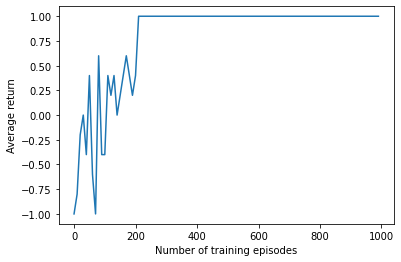

In [ ]:
#@title Running Deep Q-Learning { form-width: "30%" }  

num_episodes = 1000
num_eval_episodes = 10
eval_every_N = 10

env = dm_catch.Catch(rows=5)
dqn_agent = DQNAgent(
    env=env, gamma=.9, eps=.3, learning_rate=3e-4, buffer_capacity=1000, min_buffer_capacity=32, batch_size=32, target_ema=.9,
)

def run_dqn_episode(dqn_agent: DQNAgent, env: dm_catch.Catch, eval: bool) -> float:
  # Reset any counts and start the environment.
  timestep = environment.reset()
  dqn_agent.first_observe(timestep.observation)

  # Run an episode.
  while not timestep.last():

    # Generate an action from the agent's policy and step the environment.
    action = dqn_agent.act(timestep.observation, eval)
    timestep = environment.step(action)
    next_state = timestep.observation
    reward = timestep.reward
    done = timestep.last()
    if not eval:
      dqn_agent.observe(action, reward, done, next_state)

  return reward
  

print("Episode number:\t| Average reward on 100 eval episodes")
print("------------------------------------------------------")

episodes = []
all_rewards = []
for episode in range(num_episodes):
  run_dqn_episode(dqn_agent, environment, eval=False)

  if episode % eval_every_N == 0:
    reward = np.mean([run_dqn_episode(dqn_agent, environment, eval=True) for _ in range(num_eval_episodes)])
    print(f"\t{episode}\t|\t{reward}")
    all_rewards.append(reward)
    episodes.append(episode)

plt.xlabel('Number of training episodes')
plt.ylabel('Average return')
plt.plot(episodes, all_rewards)